# Prepare Data

## Installation

In [24]:
#%pip install --upgrade numpy
#%pip install --upgrade pandas
#%pip install --upgrade sklearn

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

## Load features and labels

In [26]:
# Load features
features = pd.read_csv('./data/features.csv', index_col='ticker')
len(features)

7151

In [27]:
# Load labels (Zack's ranks)
labels = pd.read_csv('./data/labels.csv', index_col='ticker')
len(labels)

7151

In [28]:
df = pd.concat([features, labels], axis=1)
df

,shortName,sector,industry,recommendationMean,overallRisk,beta,trailingEps,forwardEps,trailingPE,forwardPE,...,revenueGrowth,dividendYield,payoutRatio,fiveYearAvgDividendYield,debtToEquity,returnOnAssets,returnOnEquity,quickRatio,currentRatio,zacks_rank
ticker,,,,,,,,,,,,,,,,,,,,,
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,2.2,8.0,1.026324,4.53,5.98,28.333334,21.463211,...,0.068,0.0071,0.1916,0.7,50.009,0.10401,0.24782,1.546,2.370,3.0
AA,Alcoa Corporation,Basic Materials,Aluminum,2.6,1.0,2.442674,-8.55,3.18,NaN,10.449685,...,-0.263,0.0118,NaN,NaN,28.399,-0.01106,-0.22429,0.692,1.799,3.0
AAC,Ares Acquisition Corporation,Financial Services,Shell Companies,NaN,NaN,0.013452,-0.07,-1.01,NaN,-10.524753,...,NaN,NaN,0.0000,NaN,NaN,-0.00911,NaN,0.006,0.009,NaN
AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,2.0,NaN,1.072739,-0.22,-0.99,NaN,-1.232121,...,0.004,NaN,0.0000,NaN,26.451,-0.07631,-0.33159,0.209,0.231,NaN
AACI,Armada Acquisition Corp. I,Financial Services,Shell Companies,NaN,NaN,NaN,-0.59,NaN,NaN,NaN,...,NaN,NaN,0.0000,NaN,NaN,-0.02213,NaN,0.033,0.033,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZVSA,"ZyVersa Therapeutics, Inc.",Healthcare,Biotechnology,NaN,NaN,NaN,-2.19,NaN,NaN,NaN,...,NaN,NaN,0.0000,NaN,0.087,-0.13853,-0.33597,0.149,0.330,NaN
ZWS,Zurn Elkay Water Solutions Corp,Industrials,Pollution & Treatment Controls,1.9,3.0,1.116730,0.27,1.12,110.148140,26.553572,...,0.419,0.0094,1.6471,NaN,38.134,0.05188,0.05138,1.511,2.976,1.0
ZYME,Zymeworks Inc.,Healthcare,Biotechnology,1.9,NaN,0.941461,2.57,-1.33,2.894942,-5.593985,...,17.569,NaN,0.0000,NaN,5.774,0.21186,0.45666,6.056,6.334,3.0


## Missing values

### Check columns with missing values

In [29]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.isna().sum().sort_values(ascending = False)

fiveYearAvgDividendYield    5244
dividendYield               4638
earningsGrowth              4570
pegRatio                    4095
trailingPE                  3904
overallRisk                 3651
zacks_rank                  3057
recommendationMean          2402
debtToEquity                2371
forwardPE                   2361
forwardEps                  2341
revenueGrowth               1989
returnOnEquity              1789
beta                        1721
priceToBook                 1671
payoutRatio                 1572
quickRatio                  1400
currentRatio                1390
returnOnAssets              1301
bookValue                    814
trailingEps                  784
sector                       707
industry                     707
ebitdaMargins                657
profitMargins                657
shortName                    145
dtype: int64

### Drop all columns with more than 3500 missing values

In [30]:
df.drop(columns=[
    # string columns (except industry)
    'shortName',
    'sector',
    #'industry',
    # columns with more than 3500 NaNs
    'fiveYearAvgDividendYield',
    'dividendYield',
    'earningsGrowth',
    'pegRatio',
    'trailingPE',
    'overallRisk'
], inplace=True)

### Drop all rows with missing values

In [31]:
df.dropna(axis=0, inplace=True)
len(df)

2557

## Convert to Z-scores by industry

Metrics should be compared between industry pairs

In [32]:
# Z-score by industry
industries = df.industry.unique()
#ind = industries[0]
for ind in industries:
    ind_mean = df[df['industry'] == ind].drop(columns=['industry', 'zacks_rank']).mean()
    ind_std = df[df['industry'] == ind].drop(columns=['industry', 'zacks_rank']).std()
    for c in ind_mean.index:
        mean = ind_mean[c]
        std = ind_std[c] or 0.0001 # Beware zero values!
        df.loc[df['industry'] == ind, c] = df.loc[df['industry'] == ind, c].subtract(mean).div(std)
df.drop(columns=['industry'], inplace=True)
#df.isna().sum()
df.dropna(inplace=True)
df.describe()

,recommendationMean,beta,trailingEps,forwardEps,forwardPE,bookValue,priceToBook,ebitdaMargins,profitMargins,revenueGrowth,payoutRatio,debtToEquity,returnOnAssets,returnOnEquity,quickRatio,currentRatio,zacks_rank
count,2.552000e+03,2.552000e+03,2552.000000,2.552000e+03,2.552000e+03,2.552000e+03,2.552000e+03,2552.000000,2.552000e+03,2552.000000,2.552000e+03,2.552000e+03,2552.000000,2.552000e+03,2.552000e+03,2.552000e+03,2552.000000
mean,-4.315600e-17,4.872452e-17,0.000000,-1.531342e-17,-1.531342e-17,5.916549e-18,3.480323e-18,0.000000,6.960646e-19,0.000000,-1.531342e-17,1.670555e-17,0.000000,-1.670555e-17,-1.670555e-17,-2.784258e-18,2.924373
std,9.723742e-01,9.727772e-01,0.972777,9.727772e-01,9.727772e-01,9.727772e-01,9.727772e-01,0.970962,9.727772e-01,0.972777,9.679295e-01,9.727772e-01,0.972777,9.727772e-01,9.727772e-01,9.727772e-01,0.853522
min,-3.336604e+00,-4.599139e+00,-11.654869,-8.148706e+00,-1.360938e+01,-1.670698e+00,-2.094672e+00,-6.226264,-6.191618e+00,-4.941659,-2.126726e+00,-2.497452e+00,-6.797789,-1.019350e+01,-2.104858e+00,-1.738613e+00,1.000000
25%,-6.943033e-01,-5.678812e-01,-0.479560,-5.715828e-01,-2.776701e-01,-5.340856e-01,-4.948356e-01,-0.373889,-3.641908e-01,-0.396028,-4.786894e-01,-4.944978e-01,-0.462764,-3.447706e-01,-5.831887e-01,-5.924512e-01,3.000000
50%,-9.556556e-02,-8.929228e-02,-0.062095,-2.255906e-01,4.625481e-02,-2.537188e-01,-2.395595e-01,0.200169,1.802320e-01,-0.126698,-2.707033e-01,-1.939340e-01,0.122784,9.631591e-02,-3.016760e-01,-2.887438e-01,3.000000
75%,6.488376e-01,4.659344e-01,0.331201,3.014444e-01,2.520507e-01,1.996222e-01,8.974878e-02,0.512877,4.787824e-01,0.244595,0.000000e+00,1.325503e-01,0.563375,4.267273e-01,2.234381e-01,2.773767e-01,3.000000
max,3.602579e+00,1.391021e+01,5.065560,9.126166e+00,6.176713e+00,1.136090e+01,1.230601e+01,3.071068,1.161311e+01,12.885708,1.276440e+01,1.183174e+01,3.231331,6.663491e+00,6.641710e+00,7.562924e+00,5.000000


min/max do not show ouliers 

In [33]:
df.to_csv('./data/data.csv', index=True, index_label='ticker')

## PCA Analysis

In [34]:
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1:].to_numpy().ravel()
print(len(X), len(y))

2552 2552



Component 1 
Fraction of total variance explained by this variable: 0.24479340087333382 
 Total fraction of variance explained by the first 1 variable(s): 0.24479340087333382

Component 2 
Fraction of total variance explained by this variable: 0.12478968501418641 
 Total fraction of variance explained by the first 2 variable(s): 0.3695830858875202

Component 3 
Fraction of total variance explained by this variable: 0.09085928121386341 
 Total fraction of variance explained by the first 3 variable(s): 0.46044236710138364

Component 4 
Fraction of total variance explained by this variable: 0.07588406954046464 
 Total fraction of variance explained by the first 4 variable(s): 0.5363264366418483

Component 5 
Fraction of total variance explained by this variable: 0.07364311558623772 
 Total fraction of variance explained by the first 5 variable(s): 0.609969552228086

Component 6 
Fraction of total variance explained by this variable: 0.06736830905855264 
 Total fraction of variance explai

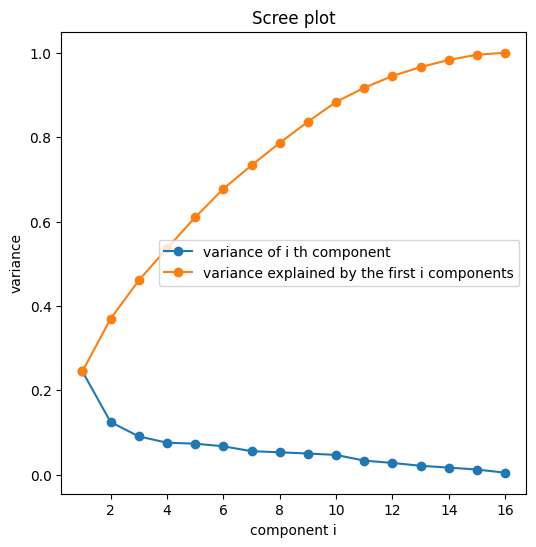

In [35]:
# First we standardize the data
scaler = StandardScaler().fit(X)
data_scaled = scaler.transform(X)

# then we perform PCA
n = len(X[0])
pca_scaled = PCA(n).fit(data_scaled)
var_scaled = pca_scaled.explained_variance_ratio_
var_scaled_explained = np.zeros(n)
for i in range(n):
    var_scaled_explained[i] = sum(var_scaled[:i+1])

for i in range(n):
    print("\nComponent", i+1 , "\nFraction of total variance explained by this variable:", var_scaled[i],
            "\n Total fraction of variance explained by the first %s variable(s):" % (i +1), var_scaled_explained[i] )

plt.figure(figsize = (6,6))
plt.plot(range(1, len(var_scaled_explained)+1), var_scaled, label = "variance of i th component", marker = "o")
plt.plot(range(1, len(var_scaled_explained)+1), var_scaled_explained, label = "variance explained by the first i components", marker = "o")
plt.xlabel("component i")
plt.ylabel("variance")
plt.title("Scree plot")
plt.legend()
plt.show()

11 components needed to capture more than 90% of the variance